## Hands-on: Profiled Correlation Power Analysis

The last session concluded with the observation that the Hamming Weight leakage hypothesis has certain limitations: although it allows significant correlation values to be obtained, the last exercise clearly showed that classes assumed to have the same Hamming Weight had very different mean trace behavior

As an introduction to profiled attacks, we propose to overcome these limitations and implement a so-called profiled correlation power analysis. The idea behind it is quite simple: instead of using an a priori known model to model leakage, we'll use a profile of it. 

Remember the first session, in which we approximated the behavior of the traces associated with the fixed value of the target variable as the average of different traces measured when this value was manipulated. The idea here is the same: instead of using an a priori-known model, we're going to create it ourselves on the basis of actual measurements during a so-called training phase. To do this, we'll operate in two steps: (1) we'll create the models in a first step, and (2) we'll perform a classic CPA, but using our brand new models instead of HW values.

### Step 1: building the models
In this section, we'll create the models together. As already mentioned, we'll calculate the average trace associated with each Sboxes output, for all 256 possible values. The aim of this step is to calculate the $16\times256=4096$ different averaged traces.

To help you solve the exercise, we'll divide the construction into different sub-steps. The first consists in calculating the average trace associated with a given class for a single variable. To do so, you have to implement the function `empirical_model_single_class` defined next:


In [1]:
import numpy as np
# TODO: implement this function
def empirical_model_single_class(traces, var_labels, label):
    """
    Compute the empirical model associated to a single class of a single variable.

    traces: the traces, as an array of shape (ntraces, nsamples)
    var_labels: the class labels taken by the variable for each traces, as an array of shape (ntraces,)
    label: the targeted class

    return: the averaged trace corresponding to the variable class, as an array of shape (nsamples,)
    """
    ###ANSWER_START
    return np.mean(traces[var_labels==label],axis=0)
    ###ANSWER_STOP

You can verify your implementation here:

In [2]:
from utils_scale import test_scale
test_scale.test_empirical_model_single_class(empirical_model_single_class)

Good job! Your implementation seems correct :)


In a second phase, your aim is to integrate this function in order to calculate all the models exhaustively. To do so, you have to implement the function `cpa_empirical_model_sbox_out` defined next:


In [3]:
import numpy as np
# TODO: implement this function
def empirical_model(traces, labels, nclasses):
    """
    Compute the empirical model associated to the Sbox outputs provided.
    
    traces: the training traces, as numpy array of shape (ntraces, nsamples)
    labels: the class label of the variables (e.g., sboxes outputs), as a numpy array of shape (ntraces, nvars). 
            the labels MUST be in range [0, nclasses-1]
    nclasses: the amounf of different classes considered (e.g., 256 if we target 8-bit variables).
    
    returns: the models, as a numpy array of shape (nvars, classes, nsamples), where
    models[i,j,k] is the model of the k-th samples in the traces, for the j-th class of the i-th variable. 
    """
    ###ANSWER_START
    # Allocate memory
    models = np.zeros([labels.shape[1], nclasses, traces.shape[1]],dtype=np.float64)
    for vi in range(labels.shape[1]):
        for ci in range(nclasses):
            models[vi, ci, :] = empirical_model_single_class(traces, labels[:,vi], ci)
    return models
    ###ANSWER_STOP

You can verify your implementation here

In [4]:
from utils_scale import test_scale
test_scale.test_cpa_empirical_model_sbox_out(empirical_model)

Good job! Your implementation seems correct :)


## Step 2: using the model

Now that we've got what we need to create the models, all that's left is to exploit them. Before implementing the attack, we'll first check whether they can improve the correlation values obtained. The following code snippets compute and display the correlation for a single byte, both using the HW and you empirical model. 

What do you observe? What do you expect regarding the performances of the CPA? 


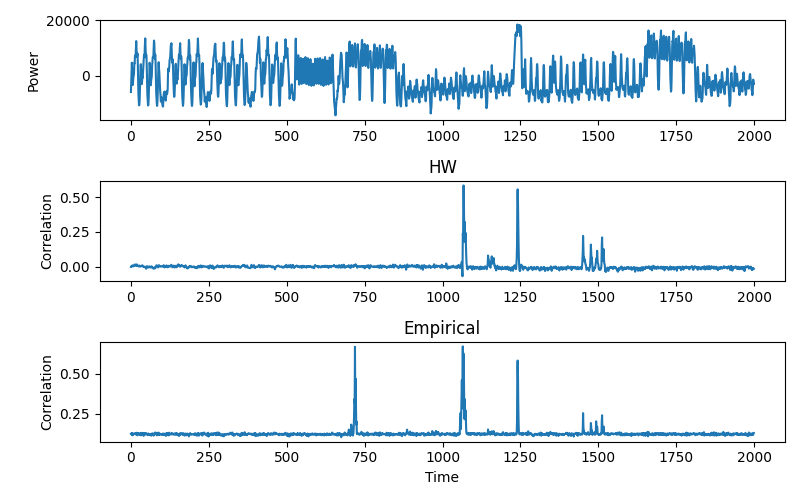

In [5]:
from utils_scale.test_scale import ref_pearson_corr
from utils_scale import utils_files, utils_aes, utils_cpa, utils_plot
%matplotlib widget
import matplotlib.pyplot as plt

# Cropping windows
# TODO, you may want to change here
start = 2500
end = 4500

# Load the dataset
ds = utils_files.load_dataset(utils_files.TRAINING_DS[0],cropping=[start,end])

# build the Hamming Weight model
hw_model = np.tile(utils_aes.HW[np.newaxis,:,np.newaxis], (16, 1, ds['traces'].shape[1])).astype(np.float64)
# Compute the Empirical model
classes = utils_aes.Sbox[ds['pts'] ^ ds['ks']]
emp_model = empirical_model(ds['traces'], classes, 256)

bindex = 2
# Compute the correlation
corr_hw = ref_pearson_corr(ds["traces"], hw_model[bindex,classes[:,bindex]])
corr_emp = ref_pearson_corr(ds["traces"], emp_model[bindex,classes[:,bindex]])

# Display
utils_plot.display_HW_emp_corr(ds['traces'][0], corr_hw, corr_emp)
    

As a final step, try to implement the full CPA using the model you build. 

In [6]:
import numpy as np
from utils_scale import utils_files, utils_cpa
from utils_scale import utils_aes
%matplotlib widget
import matplotlib.pyplot as plt
#TODO implement the following function
def cpa_out_sbox_profiled(traces, pts, models_sbox_out):
    """ 
    Perform a CPA targeting the sbox output, for several subkey, using a defined model.

    traces: the traces, as an array of shape (nexec, nsamples)
    pts: the plaintexts used, as an array of shape (nexec, nvars)
    models: the models to use, as an array of shape (nvars, nclasses, nsamples)

    Returns: a NumPy array of shape (nvars,), with the best key candidate 
    """
    ###ANSWER_START
    correlation_abs = np.abs(utils_cpa.scalib_corr_traces(traces,pts, models_sbox_out[:, utils_aes.Sbox, :]))
    return np.argmax(np.max(correlation_abs, axis=2), axis=1)
    ###ANSWER_STOP

### Mixing step 1 and 2

Try to adapt the following template in order to implement the two steps of the CPA. How does the attack complexity compare with the HW CPA? How do you explain it?

In [7]:
from utils_scale import utils_files, utils_cpa
### STEP 1: model building
# Dataset used to build the profiles. We use as much traces as possible here
ds = utils_files.load_dataset(utils_files.TRAINING_DS[0])

# Create the models
# TODO: adapt here in order to assign the variable emp_model.
# it should contain the empirical model as an array of shape (16,256,nsamples)
emp_model=None
###ANSWER_START
classes = utils_aes.Sbox[ds['pts'] ^ ds['ks']]
emp_model = empirical_model(ds['traces'], classes, 256)
###ANSWER_END

In [24]:
### Step 2: attack
# Dataset using a fixed key that we attack
ds = utils_files.load_dataset(utils_files.VALIDATION_DS[2])

# TODO: modify here
q_a = 57

# CPA 
# TODO: try to adapt here. The value of kguess MUST be an array of 16 bytes
# corresponding to the key you guessed
kguess = None
###ANSWER_START
kguess = cpa_out_sbox_profiled(ds['traces'][:q_a], ds['pts'][:q_a], emp_model)
###ANSWER_STOP

for kg, kc in zip(kguess, ds["ks"][0]):
    print(f"found {kg} --> must be {kc}: {"SUCCESS" if kg==kc else "FAILURE"}")

found 28 --> must be 28: SUCCESS
found 107 --> must be 212: FAILURE
found 103 --> must be 103: SUCCESS
found 75 --> must be 75: SUCCESS
found 146 --> must be 244: FAILURE
found 145 --> must be 145: SUCCESS
found 2 --> must be 2: SUCCESS
found 218 --> must be 218: SUCCESS
found 179 --> must be 179: SUCCESS
found 131 --> must be 131: SUCCESS
found 69 --> must be 69: SUCCESS
found 96 --> must be 96: SUCCESS
found 54 --> must be 54: SUCCESS
found 17 --> must be 17: SUCCESS
found 244 --> must be 244: SUCCESS
found 112 --> must be 112: SUCCESS


# Detection and mapping

In general, profiled attacks are divided into two distinct phases: the profiling phase and the attack phase. In the first phase, an adversary is assumed to have access to a device similar to the one being attacked to create a leakage model. This model is then used in the attack phase to retrieve information about the value of the key manipulated by the targeted device.

Although the profiling phase makes it possible to reduce the number of traces needed to carry out the attack during the online phase, it comes with the difficulty of having to profile the device, which can be costly depending on the length of traces and the number of dimensions used. Faced with these limitations, detection and mapping methodologies emerge as a first strategy to reduce the profiling overheads. Their goal is to identify the time samples in the traces that carry information, allowing an adversary to focus data manipulation efforts only on these. Such time samples are depicted as Points Of Interest (POIs).

Next, we will deal with detection strategies commonly encountered in the literature. These have different advantages and disadvantages, and their use mainly depends on the opponent's objectives and constraints.

To identify POIs, we need to define what we are looking for when examining the traces. A hypothesis commonly used in the literature is to consider that leakage with respect to an intermediate variable can be characterized in two parts: the first is deterministic and depends on the target value, and the second is random and represents noise. Using the notation from Section 2.2 of the book, the $j$-th time sample of a trace with respect to the S-box output value denoted $z_i$ can be represented as:


$$l_j(z_i) = \delta_j (z_i) + r_j$$

where $\delta_j$ is the leakage deterministic part of the $j-$th time sample and $r_j$ is an additive noise.

In fact, you've already used a detection strategy: correlation! Remember the exercises related to the (Profiled-)CPA, the correlation peaks displayed typically appear at the time sample where the intermediate state used to model the leakage is actually manipulated by the implementation!
Next, we will see two others commonly used POIs detection techniques: the Signal-to-Noise Ratio and the Welch's T-test.


## Signal-to-Noise Ratio (SNR)

The second detection method we cover here is the Signal-to-Noise Ratio (SNR). As hinted by its name, it consists of computing the ratio between the signal and the noise levels, as detailed in Section 2.2.2 of the book.

On one hand, the signal can be intuitively seen as the variation between the deterministic part of the signal for each possible value taken by \( z_i \). However, characterizing this precisely in practice can be challenging. Instead, it is estimated by averaging several traces belonging to the same class (i.e., the traces collected for a given value taken by \( z_i \)), which is

$$\hat{\delta}_j(z_i) = \hat{\mathsf{E}}(L_j(z_i))$$. 

On the other hand, the noise is the variation that occurs in the measurements when the deterministic part is fixed. It can be estimated as the variance of the noise samples, defined as

$$r_j = l_j(z_i) - \hat{\delta}_j(z_i)$$

In our AES case study, we are interested in detecting the leakage of the independent 16 bytes at the S-box outputs. When targeting a single byte, the dataset composed of \( q \) traces is split into 256 different subsets (i.e., 1 per class) in order to estimate the means and the variances. Usually, the SNR is computed using intermediate variables following a uniform distribution in order to avoid biases, and the resulting subsets are composed of \( q/256 \) traces each. In such a case, the SNR is defined as (see Section 2.2.2, Eq. (5) in the book):

$$\hat{\mathsf{SNR}}_q = \dfrac{\hat{\mathsf{Var}}_{256}(\hat{\mathsf{E}}_{q/256}(L_j(z_i)))}{\hat{\mathsf{E}}_{256}(\hat{\mathsf{Var}}_{q/256}(L_j(z_i)))}$$ 

Next, your goal is to implement the SNR. For this exercise, we consider only the SNR related to a single 8-bit intermediate variable, so you can consider that the class indexes provided span only in the range [0, 255]. 
To help you get some intuition on what it is, we split the implementation such that it can be carried out step by step. 

First, you have to compute the so-called "signal" associated to a specific 8-bit variable by implementing the function `compute_byte_signal`, defined next:

-*hint: First, compute the means of the subset of traces corresponding to a given class. Then, compute the variance of the means you just computed.*


In [9]:
def compute_byte_signal(traces, classes):
    """
    Compute the signal part of the SNR (i.e., its numerator)
    
    traces: the traces on which to compute the SNR, organised as a numpy array of float of shape (ntraces, nsamples)
    classes: for each traces, the class index associated as a numpy array of shape (ntraces, ). 
    
    return: the signal (i.e., numerator) part of SNR the computed for each time samples, as an array of shape (nsamples,)
    """
    ###ANSWER_START
    means = np.zeros([256, traces.shape[1]])
    for i in range(256):
        means[i] = np.mean(traces[classes==i,:],axis=0)
    return np.var(means, axis=0)
    ###ANSWER_STOP


You can verify your implementation next:

In [10]:
from utils_scale import test_scale
test_scale.test_snr_signal(compute_byte_signal)

Good job! Your implementation seems correct :)


Second, you have to compute the so-called "noise" associated to a specific 8-bit variable by implementing the function `compute_byte_noise`, defined next:

-*hint: First, compute the variance of the subset of traces corresponding to a given class. Then, compute the mean of the variances you just computed.*

In [11]:
def compute_byte_noise(traces, classes):
    """
    Compute the signal part
    
    traces: the traces on which to compute the SNR, organised as a numpy array of float of shape (ntraces, nsamples)
    classes: for each traces, the class index associated as a numpy array of shape (ntraces, ). 
    
    return: the signal (i.e., numerator) part of SNR the computed for each time samples, as an array of shape (nsamples,)
    """
    ###ANSWER_START
    vars = np.zeros([256, traces.shape[1]])
    for i in range(256):
        vars[i] = np.var(traces[classes==i,:], axis=0)
    return np.mean(vars, axis=0)
    ###ANSWER_STOP


You can verify your implementation next:

In [12]:
from utils_scale import test_scale
test_scale.test_snr_noise(compute_byte_noise)

Good job! Your implementation seems correct :)


Finally, you can implement the SNR in itself! You have to implement the function `compute_byte_snr` defined next:

- *NB: Relying directly on `compute_byte_signal` and `compute_byte_noise` you implemented before is sub-optimal. Don't hesitate to write it from scratch if you feel so!*

In [13]:
import numpy as np
def compute_byte_snr(traces, classes):
    """
    traces: the traces on which to compute the SNR, organised as a numpy array of float of shape (ntraces, nsamples)
    classes: for each traces, the class index associated as a numpy array of shape (ntraces, ). 
    
    return: the SNR values computed for each time samples, as an array of shape (nsamples,)
    """
    # TODO
    ###ANSWER_START
    # Allocate memory
    means = np.zeros([256, traces.shape[1]])
    vars = np.zeros([256, traces.shape[1]])
    # Iterate over each class/byte values
    for i in range(256):
        # Compute the mean for the associated trace for each time samples
        means[i] = np.mean(traces[classes==i,:],axis=0)
        # Compute the variance of the samples
        vars[i] = np.var(traces[classes==i,:], axis=0)
    # Compute the SNR
    var_means = np.var(means, axis=0)
    mean_vars = np.mean(vars, axis=0)
    return var_means / mean_vars
    ###ANSWER_STOP



You can verify your implementation here

In [14]:
from utils_scale import test_scale
test_scale.test_snr_byte(compute_byte_snr)

Good job! Your implementation seems correct :)


Use the following piece of code to display the computed SNR for the different bytes at the output of the S-box layer. What do you observe? How do the results compare with the profiled correlation POI detection strategy? How do you explain it?

Max SNR (0.8143250555370196) found at time index 1065.


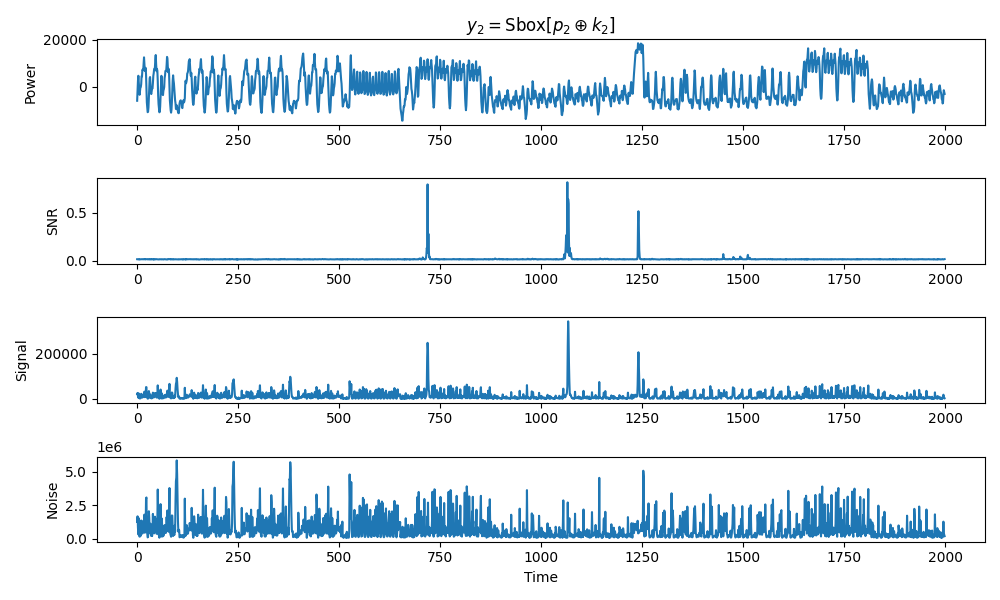

In [15]:
from utils_scale import utils_files, test_scale
from utils_scale.utils_aes import Sbox

start = 2500
end = 4500
ds = utils_files.load_dataset(utils_files.TRAINING_DS[0],cropping=[start,end])

#TODO: modify here 
bindex= 2

labels = Sbox[ds['pts'] ^ ds['ks']]
test_scale.display_snr_sbox_output(
    ds['traces'], labels, bindex, compute_byte_snr,
    subplots=[
        [compute_byte_signal, "Signal"],
        [compute_byte_noise, "Noise"],
    ])

Remember SCALib? The library also contains an implementation of the [SNR](https://scalib.readthedocs.io/en/stable/source/api/scalib.metrics.SNR.html#scalib.metrics.SNR). Try computing the SNR using SCALib and implement the function `compute_snr_scalib`.

In [16]:
from scalib.metrics import SNR

def compute_snr_scalib(traces, classes, nclasses):    
    """
    traces: the traces on which to compute the SNR, organised as a numpy array of float of shape (ntraces, nsamples)
    classes: the variables classes for each trace, as an array of shape(ntraces, nvars).  
    nclasses: the amount of different classes.
    
    return: the SNR values computed for each var at every time samples, as a numpy array of shape (nvars, nb_samples)
    """
    # TODO
    ###ANSWER_START
    snrobj = SNR(nc=nclasses)
    snrobj.fit_u(
        traces.astype(np.int16),
        classes.astype(np.uint16)
    )
    return snrobj.get_snr()
    ###ANSWER_STOP

You can test your implementation here

In [17]:
from utils_scale import test_scale
test_scale.test_snr_scalib(compute_snr_scalib)

Good job! Your implementation seems correct :)


## Welch's T-test

The next detection method discussed is the Welch T-test, as developed in Section 2.2.3 of the book. It allows reducing the data complexity required for POI detection by decreasing the number of classes for which the signal must be estimated.

As a reminder, the method consists of conducting a Welch T-test statistical test to observe if a difference of means exists between two sets of measurements (similarly to what you performed visually in the first session, but in a more systematic way). Here, the first setting we consider relies on the following sets:


- a *fixed* set of $q_{\text{f}}$ measurements, using a fixed plaintext $x_{\text{f}}$ and a fixed key $k_{\text{f}}$ for each trace.
- a *random* set of $q_{\text{r}}$ measurements, using random plaintext drawn uniformly and the fixed key $k_{\text{f}}$ for each trace.

Generally, a global dataset of $q$ measurements is collected such that $q_{\text{f}} \approx q_{\text{r}} \approx q/2$ and the latter is split in order to obtain the two datasets. From these, we can compute the following estimates for the $j$-th time sample:

$$
\begin{eqnarray}
\hat{\mu}_{\text{f}}(j) &=& \hat{\mathsf{E}}_{q_{\text{f}}}\left( L_j(x_{\text{f}}, k_{\text{f}})\right), \\
\hat{\mu}_{\text{r}}(j) &=& \hat{\mathsf{E}}_{q_{\text{r}}}\left( L_j(\$, k_{\text{f}}))\right), \\
\hat{\sigma}_{\text{f}}^2(j) &=& \hat{\mathsf{Var}}_{q_{\text{f}}}\left( L_j(x_{\text{f}}, k_{\text{f}})\right), \\
\hat{\sigma}_{\text{r}}^2(j) &=& \hat{\mathsf{Var}}_{q_{\text{r}}}\left( L_j(\$, k_{\text{f}}))\right),
\end{eqnarray}
$$

where $\$$ denotes a uniformly random value. Based on these, the T statistic for all time samples can be computed as:

$$\hat{\Delta}_{\frac{q}{2}}(j) = \dfrac{\hat{\mu}_{\text{f}}(j) - \hat{\mu}_{\text{r}}(j)}{\sqrt{\frac{\hat{\sigma}_{\text{f}}^2(j)}{q_{\text{f}}}} + \sqrt{\frac{\hat{\sigma}_{\text{r}}^2(j)}{q_{\text{r}}}}}$$

Before seeing what Ttest can achieve, try to understand how the first order (i.e., d=1) Ttest is implemented using [SCALib](https://scalib.readthedocs.io/en/stable/source/api/scalib.metrics.Ttest.html#scalib.metrics.Ttest), as presented next:








In [18]:
from scalib.metrics import Ttest

def ttest_computation(traces, labels):
    """
    traces: matrix of shape (ntraces, nsamples) containing the traces of the first set used in the statistical test
    labels: vector of shape (ntraces), containing the label of the class for each traces (i.e., either 0 or 1).
    return: a vector of shape (nb_samples,) containing the statistic values for each time samples. 
    """
    ttest_obj = Ttest(d=1)
    ttest_obj.fit_u(np.round(traces).astype(np.int16), labels.astype(np.uint16))
    return ttest_obj.get_ttest()[0]


A popular rule-of-thumb assumes POIs to be detected if the t-statistic is higher than a threshold value of 4.5, which corresponds to a probability to reject the null hypothesis below $ 10^{-5} $ (the null hypothesis being that there is no difference of mean between the fixed and random leakage sets).

Next, we want you to identify interesting time samples using the T-test as a detection method in the setting described above (we plot the threshold of 4.5 with a solid horizontal red line). 

For the first test, we propose to reproduce the analysis you performed visually, but this time using the t-statistic. We first get back to the comparison between the following datasets:
- `dataset1` that uses ($p_0$;$k_0$)
- `dataset3` that uses ($p_0$;$k_1$), and therefore uses the same plaintext as `dataset1`, but uses a different key.

Try tu run the following piece of code:

- What do you observe?
- Is this consistent with the visual observations you made earlier?

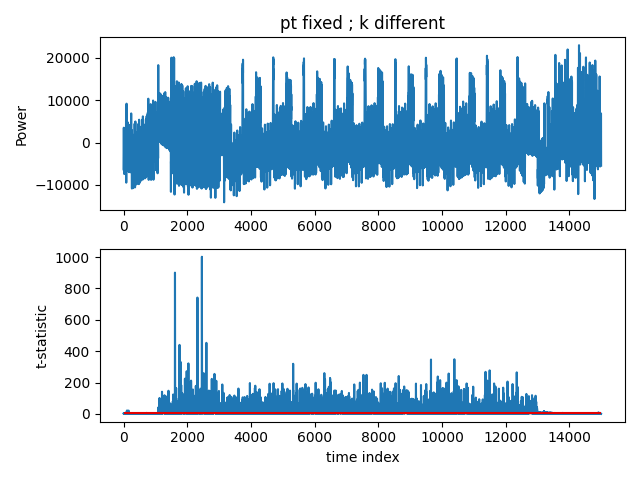

In [19]:
import numpy as np
from utils_scale import utils_obs, test_scale
%matplotlib widget
import matplotlib.pyplot as plt

## Load the dataset with different keys
ds1 = utils_obs.load_dataset_p0k0()
ds2 = utils_obs.load_dataset_p0k1()

trs = np.vstack([
    ds1['traces'],ds2['traces']
])

labels = np.array(ds1['traces'].shape[0]*[0] + ds1['traces'].shape[0]*[1])

tstat = ttest_computation(trs, labels)
test_scale.display_ttest_result(tstat, ds1['traces'][0], title="pt fixed ; k different")

For the second test, we use the following dataset instead: 

- `dataset1` that uses ($p_0$;$k_0$),
- `dataset2` that uses ($p_1$;$k_0$), and therefore uses the same key as `dataset1`, but uses a different plaintext.

Try answer the following question:

- How does it compare to the previous test?
- Is it expected?
- According to the 4.5 threshold criterion, what can you conclude? Does it make sense? Why is it happening?

Note that the following template can help you.

- *hint: As a reminder, the region in the traces between ~1600 and ~3000 correspond the the key scheduling operations that only depend on the key value*
- *hint2: The two datasets compared have been acquired sequentially, at (close yet) different moment in time.*

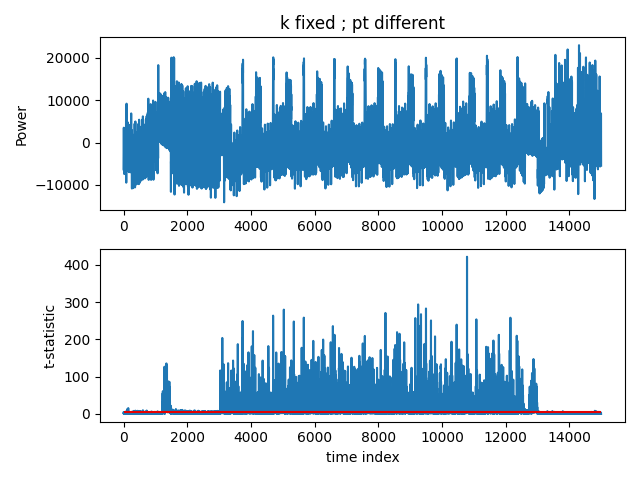

In [20]:
import numpy as np
from utils_scale import utils_obs, test_scale
%matplotlib widget
import matplotlib.pyplot as plt

## Load the dataset with different keys
ds1 = utils_obs.load_dataset_p0k0()
ds2 = utils_obs.load_dataset_p1k0()

trs = np.vstack([
    ds1['traces'],ds2['traces']
])

labels = np.array(ds1['traces'].shape[0]*[0] + ds1['traces'].shape[0]*[1])

tstat = ttest_computation(trs, labels)
test_scale.display_ttest_result(tstat, ds1['traces'][0], title="k fixed ; pt different")

The observations you have made above are a good example of how the very high sensitivity of the Ttest is both a strength and a flaw. In particular, if we refer strictly to the 4.5 threshold, the Test above seems to indicate that the keys are different (which is not the case). Because of its ultra-sensitivity, using the Ttest requires the creation of suitable setups to ensure that there is no other dependency in the consumption measurement than the data-dependent one, which as you have seen in the previous sessions is conducive to many technicalities.

In our case, we can observe that the temporal mean of the two datasets tend to be different for some part of the dataset (e.g., for the ~600 first traces as well as between the 1200-th and the 2000-th traces). This is potentially due to the fact that they were collected independently and may have undergone different environmental influences. This (small) difference may be sufficient to obtain a t-value exceeding the threshold level. 

You can run the following script to display the temporal mean of every traces in both datasets, as well as their global means. 

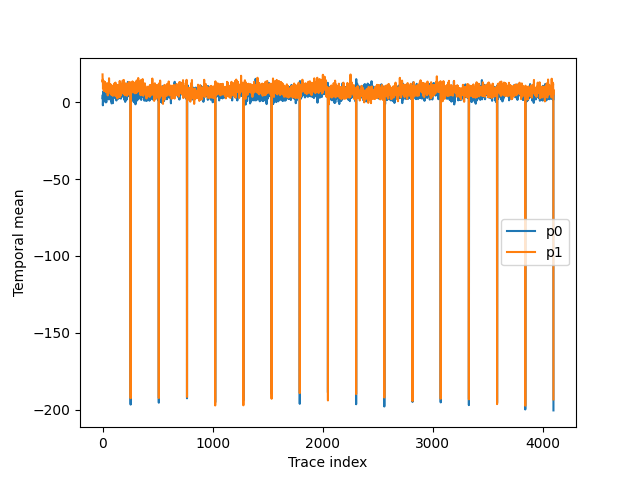

In [21]:
from utils_scale import utils_plot

## Load the dataset with different keys
ds1 = utils_obs.load_dataset_p0k0()
ds2 = utils_obs.load_dataset_p1k0()

utils_plot.plot_temporal_average(
    [ds1['traces'],ds2['traces']],
    ["p0", "p1"])

One way of reducing the apparition of these biases is to interleave the acquisition of several datasets in parallel. In practice, the configuration used for each measured execution (e.g., which plaintext is used in our example) is drawn randomly. The following code re-runs the same experiments with a dataset that has been acquired using such interleaving.

What do you observe?

- *NB: you can notice around the 500-th trace that a temporal mean shift likely occured which impacted similary both dataset due to interleaving!*

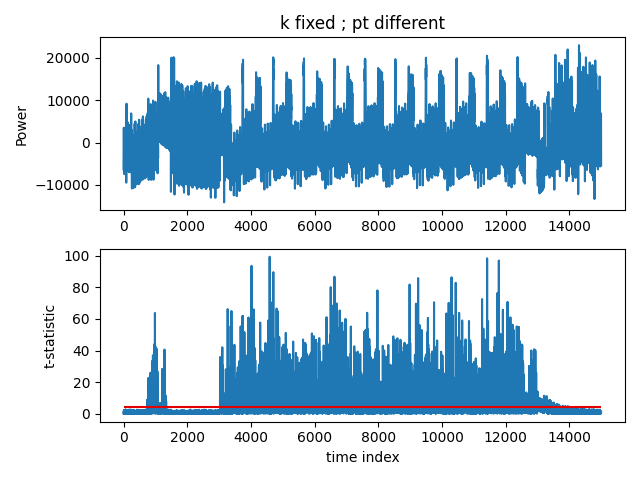

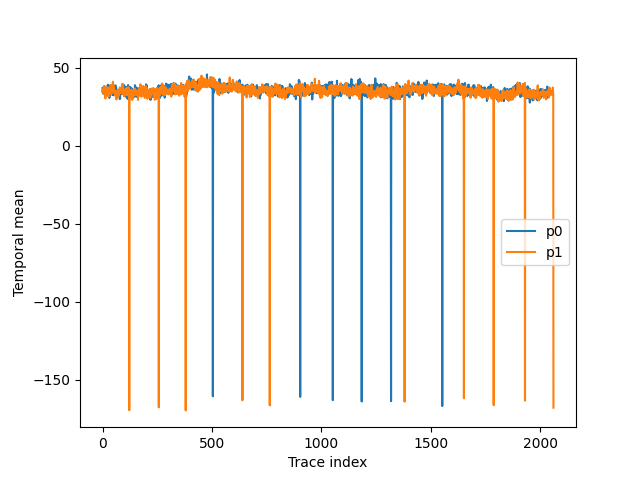

In [22]:
import numpy as np
from utils_scale import test_scale, utils_files, utils_plot
%matplotlib widget
import matplotlib.pyplot as plt

trs, _, _, labels = utils_files.load_ttest_dataset(utils_files.TTEST_KF_DS)

tstat = ttest_computation(trs, labels)
test_scale.display_ttest_result(tstat, ds1['traces'][0], title="k fixed ; pt different")

utils_plot.plot_temporal_average(
    [trs[labels==0],trs[labels==1]],
    ["p0", "p1"])

### Going further

Try to replicate the results on a "cleaned" dataset from which you have removed the traces with a significant shift in time average !